## Market Basket Analysis with Retail Sales Transactions

This data was obtain from Kaggle at the link below. It details transactional data based on scanning SKU's.

https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions

You can find more information about Market Basket Analysis at the link below.

https://medium.com/@codingml/market-basket-analysis-with-python-e695d77e0d7f

#### [Import Libraries](#import_libraries)
#### [Review Dataset](#review_dataset)
#### [Apriori & Association Rules Algorithms](#algorithms)

## <a id='import_libraries'> Import Libraries </a>

To keep things clean a single cell will be dedicated to importing libraries. In additional all libraries will be listed with a brief explanation as to why I decided to use them.

* Pandas - This is a great tool for data processing and cleaning. It organizes data into what is known as a dataframe. This is equivalent to a excel spreadsheet but, with a bit more control and pricision.

* MlXtend - The name stands for Machine Learning Extensions. It is one of the few python libraries with support for the Apriori and Association Rules algorithms.

* Numpy - Numpy has a number of mathematical functions. For this example it is used to complement Matplotlib.

* Matplotlib - A data visualization tool used to plot data on graphs. I use this for some graphs and then use Seaborn for Other. The Seaborn library allows for much simpler code.

In [1]:
# import pandas to hold data in a dataframe
import pandas as pd

# import mlxtend for pattern analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# import numpy
import numpy as np

# import visualization libraries
import matplotlib.pyplot as plt

## <a id='review_dataset'>Review Dataset</a>

The first step to analyzing the data is to first look at it. I'll do this by first importing the excel spreadsheet and placing it in a dataframe. The Pandas Python Library is used for this portion because it is commonly used for data processing and comes with a robust kit of features to manipulate data.

In [2]:
# Create a dataframe and assign data from excel spreadsheet
df = pd.read_csv(r'../input/retail-store-sales-transactions/scanner_data.csv')

# display the dataframe so we can see the data
df

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88
...,...,...,...,...,...,...,...,...
131701,131702,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,131703,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57


The dataframe as successfully imported and from running the dataframe I can tell there are 131706 rows and 8 columns of data. Some data will need more contect to determine how useful it is. And, a initial glance at the data shows that 'Unnamed:0' is a bit redundent and should be removed.

Aside from that we can see there are 7 other variables. I will list the variable descriptions then list the datatypes associate with each variable.

* Date - Date of sales transaction
* Customer_ID - ID associate with individual customers
* Transaction_ID - ID associate with each transaction. 
* SKU_Category - SKU Category ID
* SKU - SKU ID attached to unique products
* Quatity - Quantity Sold
* Sales_Amount - Unit price times quantity.


In [3]:
# delete Unnamed:0 column.
df = df.drop(['Unnamed: 0'], axis=1)

# display variable names and data types
df.dtypes

Date               object
Customer_ID         int64
Transaction_ID      int64
SKU_Category       object
SKU                object
Quantity          float64
Sales_Amount      float64
dtype: object

We have numeric and non-numeric variables. SKU, SKU_Category and Date are all non-numeric values. The SKU's don't list what the products are but that's ok. The number of unique SKU's matters and helps guide visualization.

In [4]:
# display details for numeric values
df.describe()

,Customer_ID,Transaction_ID,Quantity,Sales_Amount
count,131706.000000,131706.000000,131706.000000,131706.000000
mean,12386.450367,32389.604187,1.485311,11.981524
std,6086.447552,18709.901238,3.872667,19.359699
min,1.000000,1.000000,0.010000,0.020000
25%,7349.000000,16134.000000,1.000000,4.230000
50%,13496.000000,32620.000000,1.000000,6.920000
75%,17306.000000,48548.000000,1.000000,12.330000
max,22625.000000,64682.000000,400.000000,707.730000


In [5]:
# display details for non-numeric values
df.describe(include=['O'])

,Date,SKU_Category,SKU
count,131706,131706,131706
unique,363,187,5242
top,23/09/2016,N8U,UNJKW
freq,638,10913,2007


There are 5242 unique products in this data with 187 unique categories. There also appears to be about a year's worth of data but, there might be some typos with some of the dates. I'm going to change the data type of date to datetime to see what it does.

In [6]:
# convert dates to datetime datatype
df['Date']= pd.to_datetime(df['Date'])

# display date counts
df['Date'].value_counts()

2016-09-23    638
2016-12-15    614
2016-09-22    606
2016-05-13    602
2016-12-16    594
             ... 
2016-07-31    128
2016-03-01    111
2016-08-28    107
2016-12-24    100
2016-03-28     73
Name: Date, Length: 363, dtype: int64

Ok. So it appears the dates were originally recorded as day/month/year. Which isn't a common format for me but, it works out.

I'm curious to know how many unique customers are in the dataset. This gives us an idea of how diverse the data is and the more customers the better we can identify a trend.

In [7]:
# display unique numer of transactions
df['Transaction_ID'].nunique()

64682

In [8]:
# display unique number of customers.
df['Customer_ID'].nunique()

22625

The total number of entries 131,706. About half of that are unique transactions(64,682) and less than a quarter are unique customers(22,625). Based on this information, this store doesn't received many multi-item sales. 

Let's take a look at a graph showing the number of unique items per sale.

In [9]:
# create series counting the number of unique items in a transaction
TransCount = df.groupby(['Transaction_ID'])['SKU'].count().sort_values(ascending=True)

# create dictionary to store unique items per transaction
dict_transCount = {}

# assign unique item counts to dictionary
for i in TransCount.unique():
    dict_transCount[i] = 0
    
# count number of transactions with same unique item counts to dictionary
for j in TransCount:
    dict_transCount[j] = dict_transCount[j] + 1

# display dictionary values
dict_transCount

{1: 32906,
 2: 16845,
 3: 6802,
 4: 3478,
 5: 1851,
 6: 1036,
 7: 646,
 8: 426,
 9: 254,
 10: 167,
 11: 94,
 12: 64,
 13: 52,
 14: 23,
 15: 16,
 16: 4,
 17: 6,
 18: 4,
 19: 5,
 20: 1,
 21: 2}

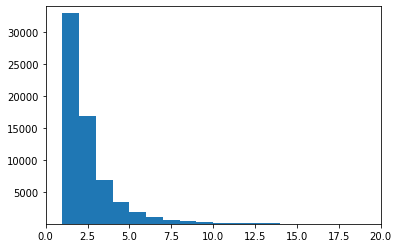

In [10]:
# plot dataset
fig, ax = plt.subplots()

ax.hist(TransCount, bins=20)

ax.set(xlim=(0,20),
      ylim=(1,34000))

plt.show()

About half of the sales are single product transactions so going forward it might be better to organize sales by customers rather than transaction ID. This will at least show what customers tend to purchase.

Let's take a look at the number of products and sales. Because the dataset is pretty large I'm going to limit the number of sales a specific item has to 10. So any items sold less than 10 will be removed from selection.

In [11]:
# generate groups by SKU and sum the quantity sold
dfilter = df.groupby(['SKU'])['Quantity'].sum().reset_index(name='Quantity')

# filter by quantity of sales greater than 10
dfilter = dfilter[dfilter['Quantity'] > 10]

# display report
dfilter

,SKU,Quantity
1,00OK1,18.0
2,0121I,31.0
3,01IEO,43.0
6,01V7M,45.0
9,03C6L,36.0
...,...,...
5230,ZVTO4,236.0
5231,ZWFSY,862.0
5233,ZWWB5,11.0
5236,ZYF2U,14.0


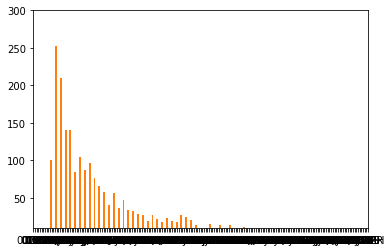

In [12]:
# plot dataset
fig, ax = plt.subplots()

ax.hist(dfilter, bins=2000, linewidth=0.1)

ax.set(xlim=(0,200),
      ylim=(10,300))

plt.show()


Next, we need to transform the data so that each product is one hot encoded. This means that every unique SKU ID will have it's own column making it easier for the algorithms to process the data.

Note: I initially ran this code using Transaction_ID but, it did not produce any results that fit the association rules criteria. Transaction_ID was replaced by Customer_ID and I was able to receive some results.

In [13]:
# one hot encode SKU's
basket = (df.groupby(['Customer_ID', 'SKU'])['Quantity']
         .sum().unstack().reset_index().fillna(0)
         .set_index('Customer_ID'))

# display dataframe
basket

SKU,00GVC,00OK1,0121I,01IEO,01IQT,01L05,01V7M,01XVY,029WA,03C6L,...,ZWNCK,ZWWB5,ZX2UM,ZY9N9,ZYF2U,ZZ2AO,ZZDW7,ZZM1A,ZZNC5,ZZX6K
Customer_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <a id='algorithms'>Apriori and Association Rules Algorithms</a>

The Apriori algorithm prefers to received the data with boolean values. It will work with 1's and 0's but that will throw an error indicating reduced support for those values in the future. So futures sake we will convert all values to True or False.

In [14]:
# function to encode all SKU fields with True or False
def encode_units(x):
    if x <= 0:
        return False
    if x >= 1:
        return True
    else: 
        return False

# apply encode_units function to the data
basket = basket.applymap(encode_units)

Now that the data is organized, we will generate a list of items that are most frequently purchased together. This is where Support, Confidence and Lift come it. For this we will look for a list of items with a support of at least 0.2%. This will generate a decent number of results to work with. It also means at least 452 customers purchased two specific items.

In [15]:
# review data
basket

SKU,00GVC,00OK1,0121I,01IEO,01IQT,01L05,01V7M,01XVY,029WA,03C6L,...,ZWNCK,ZWWB5,ZX2UM,ZY9N9,ZYF2U,ZZ2AO,ZZDW7,ZZM1A,ZZNC5,ZZX6K
Customer_ID,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22622,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22623,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# run apiori algorithm with a minimum support of 2%2
df_itemset = apriori(basket, min_support=0.002, use_colnames=True)

df_itemset

,support,itemsets
0,0.002122,(096VW)
1,0.003006,(09LL9)
2,0.002873,(0AEJH)
3,0.002387,(0B8JX)
4,0.002740,(0D3EZ)
...,...,...
583,0.004773,"(M6J9W, UNJKW)"
584,0.004155,"(UNJKW, OV1P9)"
585,0.002298,"(UNJKW, TL4WZ)"
586,0.002740,"(UQC6F, UNJKW)"


With this new item set we need to calculate the rules for each set of items and display them in our report.

In [17]:
rules = association_rules(df_itemset, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(6V2Q8),(3483Q),0.005613,0.006144,0.002033,0.362205,58.955985,0.001999,1.558269
1,(3483Q),(6V2Q8),0.006144,0.005613,0.002033,0.330935,58.955985,0.001999,1.486234
2,(3QNEE),(5O2CO),0.003624,0.002785,0.002166,0.597561,214.600271,0.002156,2.477929
3,(5O2CO),(3QNEE),0.002785,0.003624,0.002166,0.777778,214.600271,0.002156,4.483691
4,(3SZO0),(UNJKW),0.014453,0.072840,0.002431,0.168196,2.309119,0.001378,1.114637
